In [229]:
#Initial imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, plot_roc_curve, precision_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, StackingRegressor, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB

from imblearn.under_sampling import RandomUnderSampler

pd.set_option('display.max_columns', None)

In [230]:
def display_metrics(fit_model, Xtr, Xte, ytr, yte):
    '''
    This function takes in a model that's already been fit, then X and y train and test data.
    It uses the fitted model to get predicted values for the train and test data,
    and then uses sklearn's score functions to print out the accuracy, recall, precision,  f1, and roc-auc scores.
    It then plots a confusion matrix of the test data.
    '''
    train_preds = fit_model.predict(Xtr)
    test_preds = fit_model.predict(Xte)
    train_probs = fit_model.predict_proba(Xtr)[:,1]
    test_probs = fit_model.predict_proba(Xte)[:,1]

    train_accuracy = accuracy_score(ytr, train_preds)
    test_accuracy = accuracy_score(yte, test_preds)
    train_recall = recall_score(ytr, train_preds, zero_division=0)
    test_recall = recall_score(yte, test_preds, zero_division=0)
    train_precision = precision_score(ytr, train_preds, zero_division=0)
    test_precision = precision_score(yte, test_preds, zero_division=0)
    train_f1 = f1_score(ytr, train_preds, zero_division=0)
    test_f1 = f1_score(yte, test_preds, zero_division=0)
    train_rocauc = roc_auc_score(ytr, train_probs)
    test_rocauc = roc_auc_score(yte, test_probs)

    print(F'\nTrain Accuracy:\t\t{train_accuracy}')
    print(F'Test Accuracy:\t\t{test_accuracy}')
    print(F"\nTrain Recall:\t\t{train_recall}")
    print(F'Test Recall:\t\t{test_recall}')
    print(F"\nTrain Precision:\t{train_precision}")
    print(F'Test Precision:\t\t{test_precision}')
    print(F"\nTrain f1:\t\t{train_f1}")
    print(F'Test f1:\t\t{test_f1}')
    print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
    print(F'Test ROC-AUC:\t\t{test_rocauc}')
    
    plot_confusion_matrix(fit_model, Xte, yte)

In [231]:
df = pd.read_sas('../../data/nsch_2020_topical.sas7bdat')
mask = {
    1.0: 1.0,
    2.0: 0.0
}
df['Target'] = df['K2Q35A'].map(mask)
df.dropna(subset=['Target'], inplace=True)

In [232]:
drop_cols = [
    'A1_ACTIVE', 'A1_AGE', 'A1_BORN', 'A1_DEPLSTAT', 'A1_EMPLOYED', 'A1_GRADE', 'A1_LIVEUSA', 'A1_MARITAL',
    'A1_MENTHEALTH', 'A1_PHYSHEALTH', 'A1_RELATION', 'A1_SEX', 'A2_ACTIVE', 'A2_AGE', 'A2_BORN', 'A2_DEPLSTAT', 
    'A2_EMPLOYED', 'A2_GRADE', 'A2_LIVEUSA', 'A2_MARITAL', 'A2_MENTHEALTH', 'A2_PHYSHEALTH', 'A2_RELATION', 'A2_SEX', 
    'ALLERGIES_DESC', 'ARTHRITIS_DESC', 'ASKQUESTION', 'ASKQUESTION2', 'AUTISMMED', 'AUTISMTREAT', 'BESTFORCHILD', 
    'BLOOD_DESC', 'BMICLASS', 'BREASTFEDEND_DAY_S', 'BREASTFEDEND_MO_S', 'BREASTFEDEND_WK_S', 'CALMDOWN', 'CERPALS_DESC',
    'CLEAREXP', 'COLOR', 'CONFIDENT', 'COUNTTO', 'DIRECTIONS', 'DIRECTIONS2', 'DISCUSSOPT', 'DISTRACTED', 'DOCPRIVATE',
    'FAMCOUNT', 'FIPSST', 'FORMTYPE', 'FRSTFORMULA_DAY_S', 'FRSTFORMULA_MO_S','FRSTFORMULA_WK_S', 'FRSTSOLIDS_DAY_S', 
    'FRSTSOLIDS_MO_S', 'FRSTSOLIDS_WK_S', 'GENETIC_DESC', 'HCEXTENT', 'HEADACHE_DESC', 'HEART_DESC', 'HHCOUNT',
    'HHCOUNT_IF', 'HHID', 'HOURSLEEP', 'HOURSLEEP05', 'HURTSAD', 'K12Q01_A', 'K12Q01_B', 'K12Q01_C', 'K12Q01_D', 
    'K12Q01_E', 'K12Q01_F', 'K12Q01_G', 'K2Q30C', 'K2Q31C', 'K2Q32C', 'K2Q33C', 'K2Q34C', 'K2Q35A', 'K2Q35A_1_YEARS', 
    'K2Q35B', 'K2Q35C', 'K2Q35D', 'K2Q36C', 'K2Q37C', 'K2Q38C', 'K2Q40C', 'K2Q41C', 'K2Q42C', 'K2Q60C', 'K4Q26',
    'K4Q28X_EAR','K4Q37', 'K5Q11','K5Q21', 'K5Q22', 'K5Q32','K6Q08_R','K6Q10','K6Q12','K6Q13A','K6Q13B','K6Q14A','K6Q14B',
    'K6Q20','K6Q27', 'K6Q40', 'K6Q41R_STILL','K6Q42R_NEVER','K6Q43R_NEVER','K6Q60_R','K6Q61_R','K6Q70_R','K6Q72_R',
    'K6Q73_R','K9Q41', 'KEEPINSADULT','LIVEUSA_MO','LIVEUSA_YR','LIVEUSA_YR', 'K6Q42R_NEVER','MEDHISTORY','NEWACTIVITY',
    'ONEWORD','PLANNEEDS_R','PLAYWELL','POINT','RAISECONC','RECEIVECOPY','RECOGABC','RECOGBEGIN','RECSHAPES','RHYMEWORD',
    'SC_K2Q11','SC_K2Q12','SC_K2Q14','SC_K2Q15','SC_K2Q17','SC_K2Q18','SC_K2Q20','SC_K2Q21','SC_K2Q23','SC_RACEAIAN',
    'SC_RACEASIA','SESPLANMO','SESPLANYR','SIMPLEINST','SITSTILL','SLEEPPOS', 'SPCSERVMO','STARTSCHOOL','STRATUM',
    'TELLSTORY','TEMPER','THREEWORDS','TREATADULT', 'TREATNEED', 'TWOWORDS','UNDERSTAND', 'UNDERSTAND2', 'USEPENCIL', 
    'WORKTOFIN', 'WRITENAME', 'HEALTHKNOW', 'K8Q35', 'EMOSUPSPO', 'EMOSUPFAM', 'EMOSUPHCP', 'EMOSUPWOR', 'EMOSUPADV', 
    'EMOSUPPEER', 'EMOSUPMHP', 'EMOSUPOTH', 'K3Q20', 'K3Q22', 'K3Q21B', 'K7Q02R_R', 'DOCROOM', 'K4Q02_R', 'DENTISTVISIT', 
    'FWC', 'A1_GRADE_IF', 'FPL_IF', 'HIGRADE_TVIS', 'HIGRADE', 'INSTYPE', 'INSGAP', 'CURRINS', 'HOUSE_GEN', 'SC_SEX_IF', 
    'SC_HISPANIC_R_IF', 'SC_RACE_R_IF', 'TOTFEMALE', 'TOTMALE', 'AGEPOS4', 'SC_AGE_LT10', 'SC_AGE_LT9', 'SC_AGE_LT6', 
    'SC_AGE_LT4', 'TOTNONSHCN', 'TOTCSHCN', 'TOTAGE_12_17', 'TOTAGE_6_11', 'TOTAGE_0_5', 'MPC_YN', 'YEAR', 'K3Q04_R', 
    'TENURE'
]

no_cols = [
    'SC_SEX', 'K4Q32X01', 'K4Q32X02', 'K4Q32X03', 'K4Q32X04', 'K4Q32X05', 'DENTALSERV1', 'DENTALSERV2', 'DENTALSERV3',
    'DENTALSERV4', 'DENTALSERV5', 'DENTALSERV6', 'DENTALSERV7', 'K4Q28X01', 'K4Q28X02', 'K4Q28X03', 'K4Q28X04', 'K4Q28X05',
    'BREATHING', 'SWALLOWING', 'STOMACH', 'PHYSICALPAIN', 'HANDS', 'COORDINATION', 'TOOTHACHES', 'GUMBLEED', 'CAVITIES',
    'MEMORYCOND', 'WALKSTAIRS', 'DRESSING', 'ERRANDALONE', 'K2Q43B', 'BLINDNESS', 'ALLERGIES', 'ALLERGIES_CURR',
    'ARTHRITIS', 'ARTHRITIS_CURR', 'K2Q40A', 'K2Q40B', 'K2Q61A', 'K2Q61B', 'K2Q41A', 'K2Q41B', 'K2Q42A', 'K2Q42B', 'HEART',
    'HEART_BORN', 'HEART_CURR', 'HEADACHE', 'HEADACHE_CURR', 'K2Q38A', 'K2Q38B', 'K2Q33A', 'K2Q33B', 'K2Q32A', 'K2Q32B',
    'DOWNSYN', 'BLOOD', 'SICKLECELL', 'THALASSEMIA', 'BLOOD_OTHER', 'BLOOD_SCREEN', 'CYSTFIB', 'CYSTFIB_SCREEN', 'GENETIC',
    'GENETIC_SCREEN', 'K2Q34A', 'K2Q34B', 'K2Q36A', 'K2Q36B', 'K2Q60A', 'K2Q60B', 'K2Q37A', 'K2Q37B', 'K2Q30A', 'K2Q30B',
    'K2Q31A', 'K2Q31B', 'K2Q31D', 'ADDTREAT', 'CONCUSSION', 'SEEKCARE', 'CONFIRMINJURY', 'K2Q05', 'OVERWEIGHT', 'K4Q01',
    'USUALGO', 'USUALSICK', 'K4Q31_R', 'K4Q23', 'ALTHEALTH', 'K4Q27', 'NOTELIG', 'AVAILABLE', 'APPOINTMENT', 'TRANSPORTCC',
    'NOTOPEN', 'ISSUECOST', 'HOSPITALSTAY', 'SESCURRSVC', 'K4Q36', 'K4Q38', 'K5Q10', 'DECISIONS', 'K12Q03', 'K12Q04',
    'K12Q12', 'TRICARE', 'K11Q03R', 'HCCOVOTH', 'K3Q25', 'REPEATED', 'K7Q30', 'K7Q31', 'K7Q32', 'K7Q37', 'K7Q38', 'ACE3',
    'ACE4', 'ACE5', 'ACE6', 'ACE7', 'ACE8', 'ACE9', 'ACE10', 'ACE12', 'ACE1', 'K7Q04R_R', 'WGTCONC', 'K4Q22_R', 'K4Q24_R',
    'K4Q24_R', 'K4Q04_R', 'K5Q31_R',  'BIRTHWT', 'BIRTHWT_L', 'BIRTHWT_VL', 'SC_K2Q22', 'SC_K2Q19', 'SC_K2Q16', 'SC_K2Q13',
    'SC_K2Q10', 'SC_CSHCN', 'K4Q30_R', 'K4Q30_R'
]

yes_cols = [
    'S4Q01', 'CURRCOV', 'BORNUSA'
]

mode_cols = [
    'HHLANGUAGE', 'K9Q40', 'K11Q60', 'K11Q61', 'K11Q62', 'S9Q34', 'K10Q11', 'K10Q12', 'K10Q13', 'K10Q14', 'K10Q20',
    'K10Q22', 'K10Q23', 'K9Q96', 'BULLIED_R', 'BULLY', 'TOTKIDS_R', 'SC_AGE_YEARS', 'BIRTH_MO', 'BIRTH_YR', 'SC_RACER', 
    'SC_RACE_R'
]
med_cols = [
    'MOMAGE', 'K11Q43R', 'K2Q01', 'K2Q01_D', 'K6Q71_R', 'TALKABOUT', 'WKTOSOLVE', 'STRENGTHS', 'HOPEFUL', 'K10Q30',
    'K10Q31', 'K10Q40_R', 'GOFORHELP', 'K10Q41_R', 'HOWMUCH', 'K8Q31', 'K8Q32', 'K8Q34', 'ATHOMEHC', 'ARRANGEHC',
    'SCREENTIME', 'K8Q11', 'HCABILITY', 'K8Q30', 'K8Q21', 'FAMILY_R', 'BIRTHWT_OZ_S', 'SC_ENGLISH', 'MAKEFRIEND',
    'BEDTIME', 'K7Q33'
]

med_flag_cols = [
    'K5Q40', 'K5Q41', 'K5Q42', 'K5Q43', 'K5Q44', 'FOODSIT', 'MENBEVCOV'
]

five_cols = [
    'K7Q84_R', 'K7Q85_R', 'K7Q82_R', 'K7Q83_R', 'K7Q70_R', 'K8Q21'
]

bool_cols = [*no_cols, *yes_cols]
use_cols = [*no_cols, *yes_cols, *mode_cols, *med_cols, *med_flag_cols, *five_cols]

for col in df.columns:
    if col not in use_cols and col not in drop_cols:
        if (df[col].isna().sum() / len(df)) > .5:
            drop_cols.append(col)

In [233]:
bool_mask = {
    1: 1,
    2: 0,
    3: 0
}

for col in bool_cols:
    df[col] = df[col].map(bool_mask)
    
no_imp = Pipeline(steps=[
    ('no_imp', SimpleImputer(strategy='constant', fill_value=0))
])
yes_imp = Pipeline(steps=[
    ('yes_imp', SimpleImputer(strategy='constant', fill_value=1))
])

mode_imp = Pipeline(steps=[
    ('mode_imp', SimpleImputer(strategy='most_frequent'))
])

med_imp = Pipeline(steps=[
    ('med_imp', SimpleImputer(strategy='median'))
])

med_flag_imp = Pipeline(steps=[
    ('med_flag_imp', SimpleImputer(strategy='median', add_indicator=True))
])

five_imp = Pipeline(steps=[
    ('five_imp', SimpleImputer(strategy='constant', fill_value=5))
])

In [234]:
full_preprocessor = ColumnTransformer(transformers=[
    ('no_pre', no_imp, no_cols),
    ('yes_pre', yes_imp, yes_cols),
    ('mode_pre', mode_imp, mode_cols),
    ('med_cols', med_imp, med_cols),
    ('med_flag_cols', med_flag_imp, med_flag_cols),
    ('five_cols', five_imp, five_cols)
])

In [235]:
df = df.drop(columns=[*drop_cols])

y = df['Target']
X = df.drop(columns=['Target'])

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  random_state=0, stratify=y)

In [237]:
rus = RandomUnderSampler(random_state=42, replacement=True)

In [238]:
x_rus, y_rus = rus.fit_resample(X_train, y_train)

In [239]:
logreg = Pipeline(steps=[
    ('preprocessor', full_preprocessor),
    ('logreg', LogisticRegression(max_iter=5000))
])

In [240]:
logreg.fit(x_rus, y_rus)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('no_pre',
                                                  Pipeline(steps=[('no_imp',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['SC_SEX', 'K4Q32X01',
                                                   'K4Q32X02', 'K4Q32X03',
                                                   'K4Q32X04', 'K4Q32X05',
                                                   'DENTALSERV1', 'DENTALSERV2',
                                                   'DENTALSERV3', 'DENTALSERV4',
                                                   'DENTALSERV5', 'DENTALSERV6',
                                                   'DENTALSERV7', 'K4Q28X01',
                                                   'K4Q28X02', 'K4Q28X03',
          

In [241]:
logreg.score(x_rus, y_rus)

0.9426919032597266

In [242]:
tree = Pipeline(steps=[
    ('preprocessor', full_preprocessor),
    ('tree', DecisionTreeClassifier(max_features='auto', ))
])

In [243]:
tree.fit(x_rus, y_rus)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('no_pre',
                                                  Pipeline(steps=[('no_imp',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['SC_SEX', 'K4Q32X01',
                                                   'K4Q32X02', 'K4Q32X03',
                                                   'K4Q32X04', 'K4Q32X05',
                                                   'DENTALSERV1', 'DENTALSERV2',
                                                   'DENTALSERV3', 'DENTALSERV4',
                                                   'DENTALSERV5', 'DENTALSERV6',
                                                   'DENTALSERV7', 'K4Q28X01',
                                                   'K4Q28X02', 'K4Q28X03',
          

In [244]:
tree.score(x_rus, y_rus)

1.0


Train Accuracy:		1.0
Test Accuracy:		0.8352576738946775

Train Recall:		1.0
Test Recall:		0.8801261829652997

Train Precision:	1.0
Test Precision:		0.13977955911823647

Train f1:		1.0
Test f1:		0.24124513618677043

Train ROC-AUC:		1.0
Test ROC-AUC:		0.857003880956334


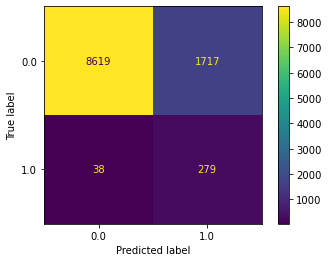

In [245]:
display_metrics(tree, x_rus, X_test, y_rus, y_test)

In [246]:
used_cols = [ *no_cols, *yes_cols, *mode_cols, *med_cols, *med_flag_cols, *five_cols]

In [247]:
used_cols_coef = list(zip(used_cols, list(*logreg.named_steps['logreg'].coef_)))
used_cols_coef

[('SC_SEX', 1.1372638360392373),
 ('K4Q32X01', -0.07305287374486921),
 ('K4Q32X02', 0.227132141740721),
 ('K4Q32X03', 0.7528769641385247),
 ('K4Q32X04', 0.30671665983386825),
 ('K4Q32X05', 0.048346795036958046),
 ('DENTALSERV1', 0.21370036897398714),
 ('DENTALSERV2', 1.1644071002958079),
 ('DENTALSERV3', -0.3133177631445379),
 ('DENTALSERV4', -0.41979847893577454),
 ('DENTALSERV5', 0.10175641452243435),
 ('DENTALSERV6', 0.0359996248157554),
 ('DENTALSERV7', 0.10077884613033901),
 ('K4Q28X01', 0.2780802154948082),
 ('K4Q28X02', 0.6166954170817089),
 ('K4Q28X03', 0.2715520417257048),
 ('K4Q28X04', 0.269915413355346),
 ('K4Q28X05', 0.25394253066397876),
 ('BREATHING', -0.4147374913169895),
 ('SWALLOWING', -0.8990381175221777),
 ('STOMACH', -0.1553772736256466),
 ('PHYSICALPAIN', -0.13569083185506525),
 ('HANDS', -0.1473122634750676),
 ('COORDINATION', -0.06209187268982319),
 ('TOOTHACHES', -0.33374780359507283),
 ('GUMBLEED', -0.5183715110752596),
 ('CAVITIES', 0.19549380577400097),
 ('ME

In [248]:
used_cols_coef = sorted(used_cols_coef, key=lambda x: x[1], reverse=True)
used_cols_coef

[('K4Q36', 1.5906872445335196),
 ('K2Q36A', 1.390373838052737),
 ('K2Q37A', 1.2806117625667388),
 ('DENTALSERV2', 1.1644071002958079),
 ('MAKEFRIEND', 1.1570404039002462),
 ('SC_SEX', 1.1372638360392373),
 ('SC_K2Q19', 1.0769317623388674),
 ('SESCURRSVC', 0.9045164036788527),
 ('K2Q34A', 0.8947317004686878),
 ('K2Q33A', 0.8454233501346812),
 ('K4Q32X03', 0.7528769641385247),
 ('K2Q41A', 0.7488990373836814),
 ('ACE6', 0.6311471915233423),
 ('K4Q28X02', 0.6166954170817089),
 ('K7Q04R_R', 0.5498763077560785),
 ('K2Q31A', 0.5490969922529056),
 ('ACE1', 0.5361165581785499),
 ('K5Q43', 0.5194684761983778),
 ('SC_K2Q22', 0.5149159641005364),
 ('K2Q32A', 0.5087493297614359),
 ('K2Q05', 0.4742884615859207),
 ('HEADACHE_CURR', 0.46658002004890037),
 ('GENETIC', 0.4610319685255724),
 ('ALTHEALTH', 0.4435026528220311),
 ('K2Q40B', 0.4297209603417413),
 ('ALLERGIES', 0.42408910609597117),
 ('K2Q30A', 0.356187950925524),
 ('ARTHRITIS', 0.3453896499674357),
 ('HEART_BORN', 0.3436593800386388),
 ('TRI

In [249]:
('K4Q36', 1.5906872445335196, 'Received Special Services: Has this child EVER received special services to meet their developmental needs such as speech,occupational, or behavioral therapy?'),
('K2Q36A', 1.390373838052737, 'Developmental Delay: Has a doctor, other health care provider, or educator EVER told you that this childhas Developmental Delay? Examples of educators are teachers and school nurses'),
('K2Q37A', 1.2806117625667388,  'Speech Disorder: Has a doctor, other health care provider, or educator EVER told you that this child has Speech or other language disorder? Examples of educators are teachers and school nurses.'),
('DENTALSERV2', 1.1644071002958079, 'Dental Service - Cleaning: : DURING THE PAST 12 MONTHS, what PREVENTIVE dental service(s) did this child receive?' ),
('MAKEFRIEND', 1.1570404039002462, 'Difficulty Making or Keeping Friends: Compared to other children their age, how much difficulty does this child have making or keeping friends?'),
('SC_SEX', 1.1372638360392373, 'Sex of Selected Child: What is sex of the child?'),
('SC_K2Q19', 1.0769317623388674, 'SC Special Therapy: Does this child need or get special therapy, such as physical, occupational, or speech therapy?'),
('SESCURRSVC', 0.9045164036788527, 'Special Education Plan - Currently: Is this child CURRENTLY receiving services under one of these plans?'),
('K2Q34A', 0.8947317004686878, 'Behavior Problems: Has a doctor, other health care provider, or educator EVER told you that this child has Behavioral or Conduct Problems? Examples of educators are teachers and school nurses.')

('K2Q34A',
 0.8947317004686878,
 'Behavior Problems: Has a doctor, other health care provider, or educator EVER told you that this child has Behavioral or Conduct Problems? Examples of educators are teachers and school nurses.')

In [250]:
better_cols = ['K4Q36', 'K2Q36A', 'K2Q37A', 'DENTALSERV2', 'MAKEFRIEND', 'SC_SEX', 'SC_K2Q19', 'SESCURRSVC', 'K2Q34A', 'K2Q33A', 'K4Q32X03']

In [251]:
no_cols = ['K4Q36', 'K2Q36A', 'K2Q37A', 'DENTALSERV2', 'SC_SEX', 'SC_K2Q19', 'SESCURRSVC', 'K2Q34A', 'K2Q33A', 'K4Q32X03']
med_cols = ['MAKEFRIEND']

bool_cols = [*no_cols]

bool_mask = {
    1: 1,
    2: 0,
    3: 0
}

for col in bool_cols:
    df[col] = df[col].map(bool_mask)
    
no_imp = Pipeline(steps=[
    ('no_imp', SimpleImputer(strategy='constant', fill_value=0))
])

med_imp = Pipeline(steps=[
    ('med_imp', SimpleImputer(strategy='median'))
])


In [252]:
better_preprocessor = ColumnTransformer(transformers=[
    ('no_pre', no_imp, no_cols),
    ('med_cols', med_imp, med_cols)
])

In [253]:
y = df['Target']
X = df[['K4Q36', 'K2Q36A', 'K2Q37A', 'DENTALSERV2', 'MAKEFRIEND', 'SC_SEX', 'SC_K2Q19', 'SESCURRSVC', 'K2Q34A', 'K2Q33A', 'K4Q32X03']]

In [254]:
X

,K4Q36,K2Q36A,K2Q37A,DENTALSERV2,MAKEFRIEND,SC_SEX,SC_K2Q19,SESCURRSVC,K2Q34A,K2Q33A,K4Q32X03
0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
42772,1.0,1.0,NaN,1.0,3.0,1.0,1.0,1.0,1.0,1.0,NaN
42773,NaN,NaN,NaN,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN
42774,1.0,1.0,1.0,NaN,3.0,NaN,1.0,1.0,1.0,NaN,NaN
42775,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [255]:
tree = Pipeline(steps=[
    ('preprocessor', better_preprocessor),
    ('tree', DecisionTreeClassifier(class_weight='balanced', 
                                    criterion='entropy', 
                                    max_depth=3,
                                    min_samples_leaf=100,
                                    min_samples_split=5,
                                    random_state=42, 
                                    splitter='best'
        
        ))
])



# max_features='auto', 
#         class_weight="balanced",
#         max_depth=10,
#         min_samples_split=30,
#          min_samples_leaf=2,
#         random_state= 42,
#        max_leaf_nodes= 16,
#         splitter= 'best',
#         criterion='entropy'

In [256]:
X_train = X_train.reindex(columns= better_cols )

In [257]:
tree.fit(X_train[better_cols], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('no_pre',
                                                  Pipeline(steps=[('no_imp',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['K4Q36', 'K2Q36A', 'K2Q37A',
                                                   'DENTALSERV2', 'SC_SEX',
                                                   'SC_K2Q19', 'SESCURRSVC',
                                                   'K2Q34A', 'K2Q33A',
                                                   'K4Q32X03']),
                                                 ('med_cols',
                                                  Pipeline(steps=[('med_imp',
                                                                   SimpleImputer(strategy='median'))]),
                

In [258]:
tree.score(X_train[better_cols], y_train)

0.914418924838851


Train Accuracy:		0.914418924838851
Test Accuracy:		0.9108232422791702

Train Recall:		0.8590956887486856
Test Recall:		0.8769716088328076

Train Precision:	0.23902867173785838
Test Precision:		0.23380992430613962

Train f1:		0.37399862668802925
Test f1:		0.3691899070385126

Train ROC-AUC:		0.941834137585092
Test ROC-AUC:		0.9480017164594545


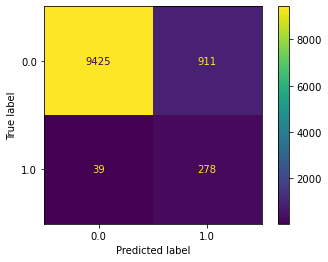

In [259]:
display_metrics(tree, X_train[better_cols], X_test[better_cols], y_train, y_test)